# 1st delete NaN

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
train_train = pd.read_csv('data/train.csv')
train_train= train_train.drop(columns=['Listening_Time_minutes'])
predict_predict = pd.read_csv('data/test.csv')

In [4]:
merge_data = pd.concat([train_train, predict_predict], axis=0, ignore_index=True)

In [5]:
merge_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 11 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   id                           1000000 non-null  int64  
 1   Podcast_Name                 1000000 non-null  object 
 2   Episode_Title                1000000 non-null  object 
 3   Episode_Length_minutes       884171 non-null   float64
 4   Genre                        1000000 non-null  object 
 5   Host_Popularity_percentage   1000000 non-null  float64
 6   Publication_Day              1000000 non-null  object 
 7   Publication_Time             1000000 non-null  object 
 8   Guest_Popularity_percentage  805138 non-null   float64
 9   Number_of_Ads                999999 non-null   float64
 10  Episode_Sentiment            1000000 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 83.9+ MB


In [6]:
merge_data.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral


In [7]:
merge_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1000000.0,499999.500000,288675.278932,0.0,249999.75,499999.50,749999.25,999999.00
Episode_Length_minutes,884171.0,153.292021,83468.998471,0.0,35.74,63.87,94.08,78486264.00
Host_Popularity_percentage,1000000.0,59.824048,22.874903,1.3,39.37,60.02,79.49,119.46
Guest_Popularity_percentage,805138.0,52.225542,28.449679,0.0,28.37,53.54,76.59,119.91
Number_of_Ads,999999.0,1.350604,2.358272,0.0,0.00,1.00,2.00,2063.00


In [8]:
merge_data.isnull().sum()

id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes         115829
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    194862
Number_of_Ads                       1
Episode_Sentiment                   0
dtype: int64

# Preprocessing of data

In [9]:

def create_features(df):
     # ジャンルごとにホストの人気度の平均を計算して，それを辞書型に変換
    #genre_to_weight = df.groupby('Genre')['Host_Popularity_percentage'].mean().to_dict()
    #df['Host_Popularity_by_Genre'] =  df['Host_Popularity_percentage'] * df['Genre'].map(genre_to_weight)
    """
    # 広告数とホスト人気の関係    
    ads_to_weight = df.groupby('Number_of_Ads')['Host_Popularity_percentage'].mean().to_dict()
    df['Host_Popularity_by_Ads'] =  df['Host_Popularity_percentage'] * df['Number_of_Ads'].map(ads_to_weight)
    
    # 視聴時間の長さ / 広告数
    ads_to_weight = df.groupby('Number_of_Ads')['Episode_Length_minutes'].mean().to_dict()
    df['Episode_Ads'] =  df['Episode_Length_minutes'] / df['Number_of_Ads'].map(ads_to_weight)

    
    """
    # ホストの人気 ＊ エピソードの長さ
    #df['Host_Popularity_by_Episode_Length'] = df['Host_Popularity_percentage'] * df['Episode_Length_minutes']

    # ホスト人気 * ゲスト人気
    #df['Host_Guest_Popularity'] = df['Host_Popularity_percentage'] * df['Guest_Popularity_percentage']
    
    return df

merge_data = create_features(merge_data)


In [10]:
def clean_abnormal_values(df):
    
    # 100%以上はクリップ（`.loc` を使って変更）
    df.loc[:, 'Host_Popularity_percentage'] = df['Host_Popularity_percentage'].clip(upper=100)
    df.loc[:, 'Guest_Popularity_percentage'] = df['Guest_Popularity_percentage'].clip(upper=100)

    df.loc[:, 'Episode_Length_minutes'] = df['Episode_Length_minutes'].clip(upper=125)
    df.loc[:, 'Number_of_Ads'] = df['Number_of_Ads'].clip(upper=12)
    
    return df

# train と predict に適用
merge_data = clean_abnormal_values(merge_data)
merge_data['Number_of_Ads'] = merge_data['Number_of_Ads'].fillna(merge_data['Number_of_Ads'].mean())

In [11]:
""" ロバストスケーリング
from sklearn.preprocessing import RobustScaler

def normalize_data(df):
    scaler = RobustScaler()
    # スケーリングを行うカラムを指定
    #columns_to_scale = ['Episode_Length_minutes', 'Number_of_Ads']
    columns_to_scale = ['Episode_Length_minutes','Number_of_Ads']
    
    # スケーリングを実行
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    
    return df

merge_data = normalize_data(merge_data)
#"""


" ロバストスケーリング\nfrom sklearn.preprocessing import RobustScaler\n\ndef normalize_data(df):\n    scaler = RobustScaler()\n    # スケーリングを行うカラムを指定\n    #columns_to_scale = ['Episode_Length_minutes', 'Number_of_Ads']\n    columns_to_scale = ['Episode_Length_minutes','Number_of_Ads']\n\n    # スケーリングを実行\n    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])\n\n    return df\n\nmerge_data = normalize_data(merge_data)\n#"

In [12]:
merge_data.nunique()

id                             1000000
Podcast_Name                        48
Episode_Title                      100
Episode_Length_minutes           12448
Genre                               10
Host_Popularity_percentage        8026
Publication_Day                      7
Publication_Time                     4
Guest_Popularity_percentage      10015
Number_of_Ads                        6
Episode_Sentiment                    3
dtype: int64

In [13]:
# columns to drop 
def delete_columns(df):
    df.drop(columns=['id'], inplace=True)
    return df

merge_data = delete_columns(merge_data)

In [14]:
merge_data.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive
1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative
2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative
3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive
4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral


# Data preparation before modeling

### Since there are few tpyes of object data,label encoding will be applied


In [15]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

def label_enocding(df,columns):
    le = LabelEncoder()

    for col in columns:
        df[col] = le.fit_transform(df[col])
    return df

encoding_cols = ['Episode_Title','Podcast_Name','Genre','Publication_Day',
                 'Publication_Time','Episode_Sentiment']

merge_data = label_enocding(merge_data, encoding_cols)


In [16]:
merge_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Podcast_Name,1000000.0,23.509140,14.130881,0.0,11.00,23.00,37.00,47.0
Episode_Title,1000000.0,50.266884,28.188012,0.0,26.00,51.00,74.00,99.0
Episode_Length_minutes,884171.0,64.515314,32.964440,0.0,35.74,63.87,94.08,125.0
Genre,1000000.0,4.646925,2.962164,0.0,2.00,5.00,7.00,9.0
Host_Popularity_percentage,1000000.0,59.823641,22.874055,1.3,39.37,60.02,79.49,100.0
Publication_Day,1000000.0,2.962779,1.996461,0.0,1.00,3.00,5.00,6.0
Publication_Time,1000000.0,1.522814,1.119155,0.0,1.00,1.00,3.00,3.0
Guest_Popularity_percentage,805138.0,52.225207,28.449038,0.0,28.37,53.54,76.59,100.0
Number_of_Ads,1000000.0,1.347844,1.111948,0.0,0.00,1.00,2.00,12.0
Episode_Sentiment,1000000.0,0.997786,0.815496,0.0,0.00,1.00,2.00,2.0


In [17]:
merge_data.isnull().sum()

Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes         115829
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    194862
Number_of_Ads                       0
Episode_Sentiment                   0
dtype: int64

In [18]:
def split_train_predict(df):
    train = df[df['Episode_Length_minutes'].notnull()]
    predict = df[df['Episode_Length_minutes'].isnull()]
    return train, predict

train, predict = split_train_predict(merge_data)

In [19]:
# Episode_Length_minutes が 1000分未満だけを使う（16時間以上の回は除外）
train = train[train['Episode_Length_minutes'] < 800]

In [20]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Podcast_Name,884171.0,23.518037,14.123905,0.0,11.00,23.00,37.00,47.0
Episode_Title,884171.0,50.334278,28.198842,0.0,26.00,51.00,75.00,99.0
Episode_Length_minutes,884171.0,64.515314,32.964440,0.0,35.74,63.87,94.08,125.0
Genre,884171.0,4.643314,2.961671,0.0,2.00,5.00,7.00,9.0
Host_Popularity_percentage,884171.0,59.837924,22.871016,1.3,39.41,60.05,79.51,100.0
Publication_Day,884171.0,2.958036,1.996968,0.0,1.00,3.00,5.00,6.0
Publication_Time,884171.0,1.524780,1.119224,0.0,1.00,2.00,3.00,3.0
Guest_Popularity_percentage,718883.0,52.221367,28.509776,0.0,28.24,53.58,76.68,100.0
Number_of_Ads,884171.0,1.350273,1.111748,0.0,0.00,1.00,2.00,12.0
Episode_Sentiment,884171.0,0.995740,0.815203,0.0,0.00,1.00,2.00,2.0


In [21]:
# 行の数
print("train shape: ", train.shape)
print("train shape: ", predict.shape)

train shape:  (884171, 10)
train shape:  (115829, 10)


In [22]:
predict.isnull().sum()

Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes         115829
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage     29574
Number_of_Ads                       0
Episode_Sentiment                   0
dtype: int64

In [23]:
train.isnull().sum()

Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes              0
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    165288
Number_of_Ads                       0
Episode_Sentiment                   0
dtype: int64

In [80]:
from sklearn.model_selection import train_test_split

def split_data(df, test_size=0.2, random_state=42):
    X = df.drop(columns=['Episode_Length_minutes'])
    y = df['Episode_Length_minutes']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(train)
predict_X = predict.copy()

# Model Construction

In [81]:
train.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
1,24,19,119.80,1,66.95,2,0,75.95,2.0,0
2,40,8,73.90,2,69.97,5,1,8.97,0.0,0
3,10,40,67.17,8,57.22,1,2,78.70,2.0,2
4,31,85,110.51,3,80.07,1,0,58.68,3.0,1
5,14,11,26.54,3,48.96,2,0,NaN,3.0,2


In [82]:
import xgboost as xgb

# XGBoostモデルの構築
def build_xgboost_model(n_estimators=100,max_depth=5,learning_rate=0.1):
    """XGBoostモデルを構築する関数"""
    model = xgb.XGBRegressor(
        # 回帰タスクに適した損失関数（MSE）
        objective='reg:squarederror',
        # 決定木の数
        n_estimators=n_estimators,
        # 決定機の深さ
        max_depth=max_depth,
        # 学習率(小さいほど安定，収束が遅くなる)
        learning_rate=learning_rate,
        # 乱数シード
        random_state=42
    )
    return model

# モデルの構築
xgb_model = build_xgboost_model()

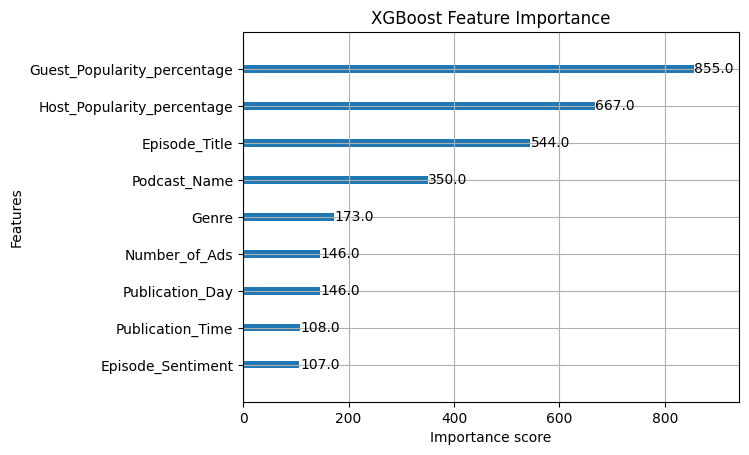

In [83]:
import matplotlib.pyplot as plt

# Train XGBoost model
xgb_model.fit(X_train, y_train) # XGBoostモデルの学習

# Feature importance
xgb.plot_importance(xgb_model) # 特徴量の重要度をプロット
plt.title('XGBoost Feature Importance') # タイトル
plt.show() # グラフの表示

# Model evalution

In [84]:
xgb_pred = xgb_model.predict(X_test)

In [85]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def evaluate_metrics(y_true,y_pred):
    
    results = []

    def calulate_metrics(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)

        return {
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2
        }
    results.append(calulate_metrics(y_true, y_pred))

    return pd.DataFrame(results)

results = evaluate_metrics(y_test, xgb_pred)
display(results)

,MSE,RMSE,R2
0,1063.744692,32.615099,0.020998


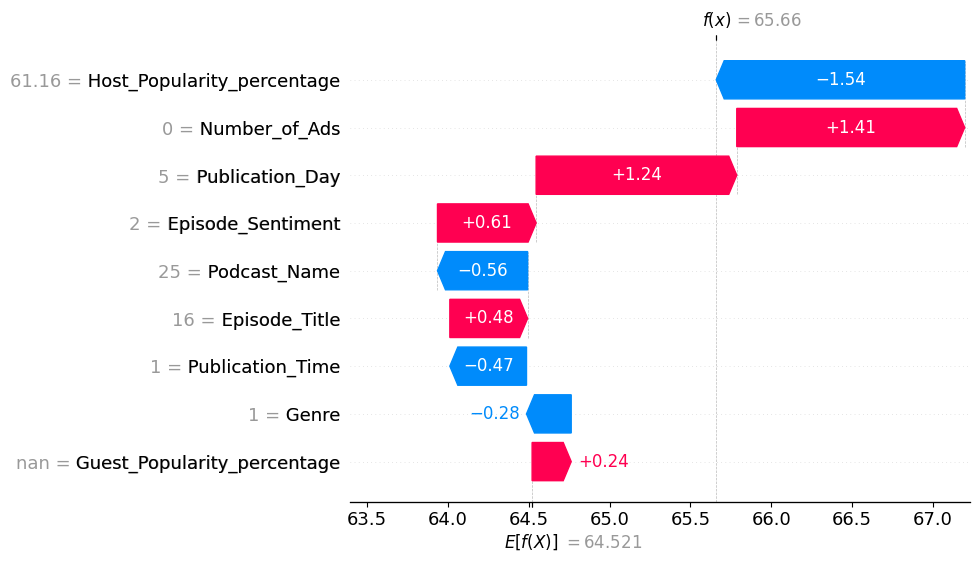

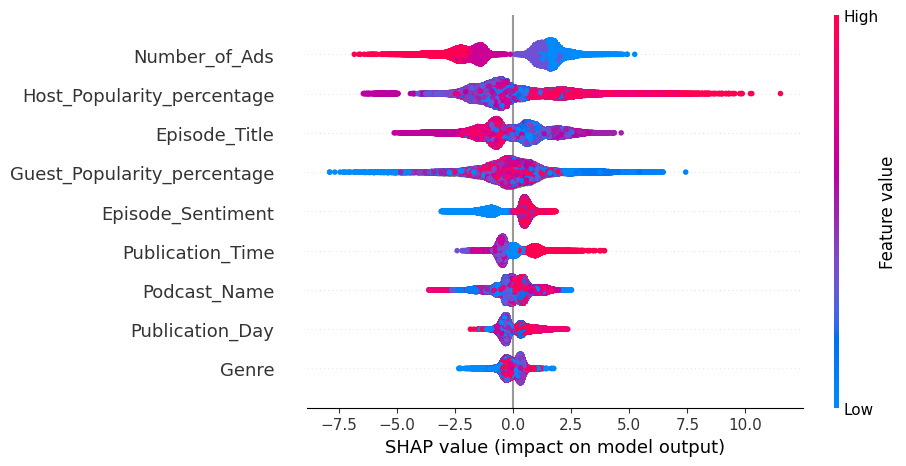

In [86]:
import shap

def explain_model(model):
    # SHAP explainerを作成（TreeExplainerはXGBoostなどに最適）
    explainer = shap.Explainer(model)

    # SHAP値を計算（X_testに対して）
    shap_values = explainer(X_test)

    # 可視化（例：1件目の予測理由）
    shap.plots.waterfall(shap_values[0])

    # 全体の特徴量の影響（要約プロット）
    shap.plots.beeswarm(shap_values)

explain_model(xgb_model)


# Optuna

In [87]:
import optuna
def optimize_xgboost(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500), # 決定木の数
        'max_depth': trial.suggest_int('max_depth', 3, 10), # 決定木の深さ
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3), # 学習率
        'subsample': trial.suggest_float('subsample', 0.6, 1.0), # サブサンプル
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0), # 列のサブサンプル
        'gamma': trial.suggest_float('gamma', 0, 1), # 葉ノードを分割するために必要な最小損失削減
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10), # 葉ノードの重みの最小合計
        'objective': 'reg:squarederror', # 回帰タスクに適した損失関数
        'random_state': 42                
    }

    model = xgb.XGBRegressor(**params)
    model = model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    return mse

study = optuna.create_study(direction='minimize')
study.optimize(optimize_xgboost, n_trials=10)

# dislay best results
print('Best trial:')
trial = study.best_trial # 最良のトライアル
print(f"  MSE: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Predict
optimized_xgb = xgb.XGBRegressor(**trial.params, random_state=42)
optimized_xgb.fit(X_train, y_train)

[I 2025-04-21 12:12:15,663] A new study created in memory with name: no-name-7c1fdbdb-d027-4550-bd83-ae38399f9311
[I 2025-04-21 12:12:18,597] Trial 0 finished with value: 1049.9679792040256 and parameters: {'n_estimators': 194, 'max_depth': 7, 'learning_rate': 0.16544073281816596, 'subsample': 0.6499563656363888, 'colsample_bytree': 0.7010343491258242, 'gamma': 0.16045514549880524, 'min_child_weight': 4}. Best is trial 0 with value: 1049.9679792040256.
[I 2025-04-21 12:12:22,145] Trial 1 finished with value: 1054.616002924101 and parameters: {'n_estimators': 375, 'max_depth': 5, 'learning_rate': 0.09972250578792057, 'subsample': 0.7706363186566363, 'colsample_bytree': 0.8322450850017314, 'gamma': 0.9422293677602379, 'min_child_weight': 5}. Best is trial 0 with value: 1049.9679792040256.
[I 2025-04-21 12:12:23,007] Trial 2 finished with value: 1068.0098788818743 and parameters: {'n_estimators': 109, 'max_depth': 3, 'learning_rate': 0.14524700020165188, 'subsample': 0.6196037516843779, '

Best trial:
  MSE: 1045.8827751003687
  Params: 
    n_estimators: 91
    max_depth: 10
    learning_rate: 0.20794514960075283
    subsample: 0.8475160610755998
    colsample_bytree: 0.8148876063609695
    gamma: 0.0024657277971104063
    min_child_weight: 10


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8148876063609695, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0.0024657277971104063, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.20794514960075283, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=91, n_jobs=None,
             num_parallel_tree=None, ...)

In [ ]:
optimized_pred = optimized_xgb.predict(X_test)
optimized_metrics = evaluate_metrics(y_test,  optimized_pred) # 評価
display(optimized_metrics)

,MSE,RMSE,R2
0,0.402193,0.480953,0.026327


In [ ]:
# 保存（バイナリ形式）
#optimized_xgb.save_model("model/xgboost/xgb_model.json")  # .json でも .model でもOK

"""
import xgboost as xgb

# モデルの読み込み
loaded_model = xgb.XGBRegressor()
loaded_model.load_model("xgb_model.json")
"""

'\nimport xgboost as xgb\n\n# モデルの読み込み\nloaded_model = xgb.XGBRegressor()\nloaded_model.load_model("xgb_model.json")\n'

In [ ]:
#submission.to_csv('submit/xgb_submit/submission4.csv', index=False)